# Proyecto Final - NLP y Deep Learning

Este proyecto integra técnicas de Procesamiento de Lenguaje Natural (NLP) y Deep Learning en el marco del curso de Ciencia de Datos. El objetivo es aplicar herramientas vistas en clase para analizar texto mediante modelos de NLP o entrenar redes neuronales multicapa con enfoque práctico.

## Dataset

Se trabajó con un dataset sintético titulado **"reseñas_concesionarias_argentina.csv"**. Este conjunto de datos fue generado exclusivamente para este proyecto, simulando reseñas de clientes sobre concesionarias de autos en Argentina. Contiene más de 2000 registros con opiniones en lenguaje natural, incluyendo atributos como texto de la reseña, puntaje otorgado y nombre de la concesionaria. No corresponde a información real, sino que fue creado con fines educativos y de práctica.

## Estructura del Proyecto

- **Carga y análisis exploratorio**: Se importó el dataset, visualizando su estructura y extrayendo insights preliminares (distribución de puntuaciones, longitud de reseñas, etc.).
- **Preprocesamiento NLP**: Se aplicaron técnicas como tokenización, lematización y eliminación de stopwords. Además, se realizó un análisis de sentimiento utilizando herramientas estándar.
- **Vectorización y clasificación**: Se implementó un pipeline con TF-IDF y regresión logística para clasificar reseñas en función de su polaridad.
- **Modelo de Deep Learning**: Se diseñó y entrenó una red neuronal multicapa (Multilayer Perceptron) con al menos dos capas ocultas, utilizando funciones de activación no lineales y softmax en la capa de salida.
- **Comparación de modelos**: Se compararon los resultados del modelo tradicional con el de deep learning, evaluando precisión y rendimiento.
- **Conclusiones**: Se discutieron los hallazgos clave, destacando ventajas y limitaciones de cada enfoque aplicado.

---

In [49]:
# --- Manejo de datos ---
import pandas as pd
import numpy as np
import requests
import operator
import time

# --- Visualización de datos ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from wordcloud import WordCloud

# --- Procesamiento de texto y NLP ---
import re
import string
import spacy
from spacy import displacy

# --- NLTK ---
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag

# --- Sklearn: modelos, métricas y vectorización ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    classification_report
)

# --- Utilidades ---
import warnings
warnings.filterwarnings('ignore')

# --- Descargar recursos necesarios de NLTK ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## El dataset

In [50]:
# URL del archivo en GitHub
url = "https://raw.githubusercontent.com/chamomatias/DataScienceIII---PF/refs/heads/main/rese%C3%B1as_concesionarias_argentina.csv"

# Leer el CSV
df_v0 = pd.read_csv(url, encoding="utf-8")

### Una primera observacion al dataset
###  Descripción de columnas – Dataset de Reseñas de Concesionarias en Argentina

Este dataset contiene 45.000 reseñas simuladas de clientes que evaluaron su experiencia en distintas concesionarias de autos en Argentina. A continuación se describen las columnas del archivo:

| Columna                   | Descripción                                                                |
| ------------------------- | -------------------------------------------------------------------------- |
| `id_reseñador`            | Identificador numérico único de cada reseñador.                            |
| `nombre_concesionaria`    | Nombre de la concesionaria donde se realizó la reseña.                     |
| `categoría`               | Tipo de establecimiento (en todos los casos: "Concesionaria de autos").    |
| `dirección`               | Dirección física de la concesionaria, incluyendo ciudad y provincia.       |
| `latitud`                 | Coordenada geográfica de latitud correspondiente a la ubicación.           |
| `longitud`                | Coordenada geográfica de longitud correspondiente a la ubicación.          |
| `cantidad_calificaciones` | Número total de calificaciones acumuladas por la concesionaria.            |
| `tiempo_reseña`           | Tiempo relativo de publicación de la reseña (e.g., "hace 5 días").         |
| `reseña`                  | Texto libre con la opinión del cliente sobre la concesionaria.             |
| `calificación`            | Evaluación textual de 1 a 5 estrellas (e.g., "1 estrella", "5 estrellas"). |

---

In [51]:
# Ver las primeras filas
df_v0.head()

,id_reseñador,nombre_concesionaria,categoría,dirección,latitud,longitud,cantidad_calificaciones,tiempo_reseña,reseña,calificación
0,1,Toyota Plan Belgrano,Concesionaria de autos,"Av. Cabildo 1234, Belgrano, CABA, Argentina",-34.5622,-58.4561,278,hace 2 semanas,Prometieron una entrega que no cumplieron.,1 estrella
1,2,Renault Pilar,Concesionaria de autos,"Ruta 8 km 52, Pilar, Buenos Aires, Argentina",-34.4557,-58.9051,654,hace 5 días,No recomiendo esta concesionaria.,1 estrella
2,3,Volkswagen Mendoza,Concesionaria de autos,"Acceso Sur 3400, Godoy Cruz, Mendoza, Argentina",-32.9343,-68.8452,273,hace 5 días,Muy mala atención al cliente.,1 estrella
3,4,Renault Pilar,Concesionaria de autos,"Ruta 8 km 52, Pilar, Buenos Aires, Argentina",-34.4557,-58.9051,624,hace 5 días,Volvería a comprar aquí sin dudas.,5 estrellas
4,5,Renault Pilar,Concesionaria de autos,"Ruta 8 km 52, Pilar, Buenos Aires, Argentina",-34.4557,-58.9051,509,hace 2 semanas,El servicio postventa funciona perfecto.,5 estrellas


In [52]:
# Reordenar las columnas: primero int, luego float, y finalmente object
int_cols = df_v0.select_dtypes(include='int').columns.tolist()
float_cols = df_v0.select_dtypes(include='float').columns.tolist()
obj_cols = df_v0.select_dtypes(include='object').columns.tolist()

nuevo_orden = int_cols + float_cols + obj_cols
df_v1 = df_v0[nuevo_orden]

display(df_v1)

,id_reseñador,cantidad_calificaciones,latitud,longitud,nombre_concesionaria,categoría,dirección,tiempo_reseña,reseña,calificación
0,1,278,-34.5622,-58.4561,Toyota Plan Belgrano,Concesionaria de autos,"Av. Cabildo 1234, Belgrano, CABA, Argentina",hace 2 semanas,Prometieron una entrega que no cumplieron.,1 estrella
1,2,654,-34.4557,-58.9051,Renault Pilar,Concesionaria de autos,"Ruta 8 km 52, Pilar, Buenos Aires, Argentina",hace 5 días,No recomiendo esta concesionaria.,1 estrella
2,3,273,-32.9343,-68.8452,Volkswagen Mendoza,Concesionaria de autos,"Acceso Sur 3400, Godoy Cruz, Mendoza, Argentina",hace 5 días,Muy mala atención al cliente.,1 estrella
3,4,624,-34.4557,-58.9051,Renault Pilar,Concesionaria de autos,"Ruta 8 km 52, Pilar, Buenos Aires, Argentina",hace 5 días,Volvería a comprar aquí sin dudas.,5 estrellas
4,5,509,-34.4557,-58.9051,Renault Pilar,Concesionaria de autos,"Ruta 8 km 52, Pilar, Buenos Aires, Argentina",hace 2 semanas,El servicio postventa funciona perfecto.,5 estrellas
...,...,...,...,...,...,...,...,...,...,...
44995,44996,433,-32.9343,-68.8452,Volkswagen Mendoza,Concesionaria de autos,"Acceso Sur 3400, Godoy Cruz, Mendoza, Argentina",hace 5 días,Me entregaron el auto con fallas.,1 estrella
44996,44997,204,-34.5622,-58.4561,Toyota Plan Belgrano,Concesionaria de autos,"Av. Cabildo 1234, Belgrano, CABA, Argentina",hace 1 mes,Muy conforme con la compra de mi auto.,4 estrellas
44997,44998,69,-34.5622,-58.4561,Toyota Plan Belgrano,Concesionaria de autos,"Av. Cabildo 1234, Belgrano, CABA, Argentina",hace 2 semanas,Prometieron una entrega que no cumplieron.,1 estrella
44998,44999,857,-34.5622,-58.4561,Toyota Plan Belgrano,Concesionaria de autos,"Av. Cabildo 1234, Belgrano, CABA, Argentina",hace 5 días,Muy conforme con la compra de mi auto.,5 estrellas


## Analisis del dataset

In [53]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_reseñador             45000 non-null  int64  
 1   cantidad_calificaciones  45000 non-null  int64  
 2   latitud                  45000 non-null  float64
 3   longitud                 45000 non-null  float64
 4   nombre_concesionaria     45000 non-null  object 
 5   categoría                45000 non-null  object 
 6   dirección                45000 non-null  object 
 7   tiempo_reseña            45000 non-null  object 
 8   reseña                   45000 non-null  object 
 9   calificación             45000 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.4+ MB


In [54]:
print("Cantidad de filas duplicadas:", df_v1.duplicated().sum())

print("-------")

print("Cantidad de valores nulos por columna:")
print(df_v1.isnull().sum())


Cantidad de filas duplicadas: 0
-------
Cantidad de valores nulos por columna:
id_reseñador               0
cantidad_calificaciones    0
latitud                    0
longitud                   0
nombre_concesionaria       0
categoría                  0
dirección                  0
tiempo_reseña              0
reseña                     0
calificación               0
dtype: int64


## Preprocesamiento de Texto

In [55]:
# Creo el data frame de trabajo
df_v2 = df_v1.copy()
df_v2 = df_v2.drop(columns=['id_reseñador','cantidad_calificaciones', 'latitud','longitud','nombre_concesionaria','categoría', 'dirección', 'tiempo_reseña'])
df_v2

,reseña,calificación
0,Prometieron una entrega que no cumplieron.,1 estrella
1,No recomiendo esta concesionaria.,1 estrella
2,Muy mala atención al cliente.,1 estrella
3,Volvería a comprar aquí sin dudas.,5 estrellas
4,El servicio postventa funciona perfecto.,5 estrellas
...,...,...
44995,Me entregaron el auto con fallas.,1 estrella
44996,Muy conforme con la compra de mi auto.,4 estrellas
44997,Prometieron una entrega que no cumplieron.,1 estrella
44998,Muy conforme con la compra de mi auto.,5 estrellas


In [56]:
# Crear df_v3 a partir de df_v2
df_v3 = df_v2.copy()

# Extraer el número de la calificación como entero
df_v3['calificacion_num'] = df_v3['calificación'].str.extract(r'(\d)').astype(int)

# Verificar resultado
df_v3.head()

,reseña,calificación,calificacion_num
0,Prometieron una entrega que no cumplieron.,1 estrella,1
1,No recomiendo esta concesionaria.,1 estrella,1
2,Muy mala atención al cliente.,1 estrella,1
3,Volvería a comprar aquí sin dudas.,5 estrellas,5
4,El servicio postventa funciona perfecto.,5 estrellas,5


## Análisis exploratorio

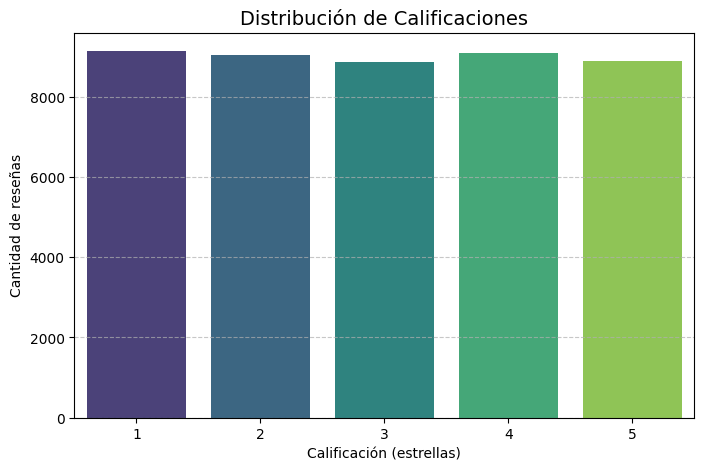

In [57]:
#Graficaremos la distribucion de las calificaciones
plt.figure(figsize=(8, 5))
sns.countplot(data=df_v3, x='calificacion_num', palette='viridis')

plt.title("Distribución de Calificaciones", fontsize=14)

plt.xlabel("Calificación (estrellas)")
plt.ylabel("Cantidad de reseñas")

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## **Observaciones:**

- La distribución de las calificaciones es pareja en todo el rango de puntuaciones, desde 1 hasta 5 estrellas.
- Cada categoría concentra aproximadamente la misma cantidad de reseñas, en torno a las 9.000 observaciones por grupo.
- Esta uniformidad resulta favorable para los modelos de clasificación, ya que reduce el riesgo de sesgo por desbalanceo de clases.


In [58]:
# Crear nueva columna de sentimiento
df_v3['sentimiento'] = df_v3['calificacion_num'].apply(lambda x: 'Positivo' if x >= 4 else 'Negativo')

# Verificar resultado
df_v3[['reseña', 'calificacion_num', 'sentimiento']].head()


,reseña,calificacion_num,sentimiento
0,Prometieron una entrega que no cumplieron.,1,Negativo
1,No recomiendo esta concesionaria.,1,Negativo
2,Muy mala atención al cliente.,1,Negativo
3,Volvería a comprar aquí sin dudas.,5,Positivo
4,El servicio postventa funciona perfecto.,5,Positivo


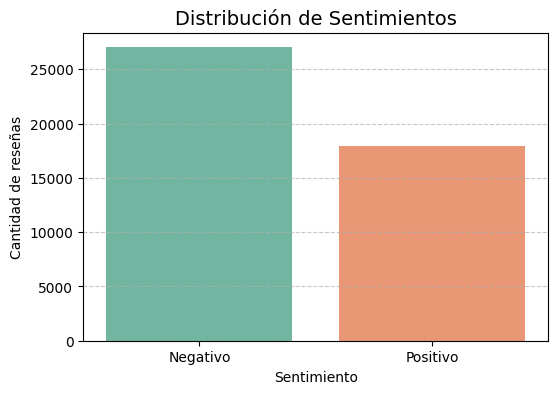

In [59]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_v3, x='sentimiento', palette='Set2')

plt.title("Distribución de Sentimientos", fontsize=14)
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de reseñas")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **Observaciones:**

- La mayoría de las reseñas expresan un sentimiento **negativo**, con más de 26.000 registros.
- Las reseñas **positivas** representan una proporción menor, con alrededor de 18.000 casos.
- Esta asimetría podría reflejar una tendencia crítica por parte de los usuarios, o bien sesgos introducidos en el proceso de generación sintética.
- Este desbalance debe tenerse en cuenta al entrenar modelos de clasificación, especialmente al evaluar métricas como recall o F1-score.


## Preprocesamiento: Limpieza de Texto

Se implementa una función de limpieza básica para normalizar el contenido textual de las reseñas. El proceso incluye:

- Conversión del texto a minúsculas.
- Eliminación de números y signos de puntuación.
- Sustitución de espacios múltiples por uno solo.
- Eliminación de espacios iniciales y finales.

Se aplica esta función sobre la columna `reseña`, generando una nueva columna `texto_limpio`. A continuación, se visualizan los primeros resultados del procesamiento:

In [60]:
import re

def limpiar_texto(texto):
    texto = texto.lower()  # Pasar a minúsculas
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar signos de puntuación
    texto = re.sub(r'\s+', ' ', texto)  # Reemplazar múltiples espacios por uno
    texto = texto.strip()  # Eliminar espacios iniciales/finales
    return texto

# Aplicar limpieza a la columna 'reseña'
df_v3['texto_limpio'] = df_v3['reseña'].apply(limpiar_texto)

# Vista previa
df_v3[['reseña', 'texto_limpio']].head()


,reseña,texto_limpio
0,Prometieron una entrega que no cumplieron.,prometieron una entrega que no cumplieron
1,No recomiendo esta concesionaria.,no recomiendo esta concesionaria
2,Muy mala atención al cliente.,muy mala atención al cliente
3,Volvería a comprar aquí sin dudas.,volvería a comprar aquí sin dudas
4,El servicio postventa funciona perfecto.,el servicio postventa funciona perfecto


## Preprocesamiento: Tokenización

Se implementa la tokenización del texto utilizando la función `word_tokenize` de la biblioteca `nltk`. Este proceso descompone las reseñas en palabras individuales (tokens), facilitando el análisis morfosintáctico y el modelado posterior.

### Pasos realizados:

- Se descarga y configura el paquete `punkt`, necesario para la segmentación léxica.
- Se define una función personalizada que aplica `word_tokenize` a cada texto limpio.
- Se crea una nueva columna `tokens` con la lista resultante de palabras por reseña.

A continuación se presenta un ejemplo del resultado:

In [61]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [62]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Definir la función de tokenización
def tokenize_text(texto):
    tokens = word_tokenize(texto)
    return tokens

# Aplicar tokenización
df_v3['tokens'] = df_v3['texto_limpio'].apply(tokenize_text)

# Ver los resultados
print(df_v3[['texto_limpio', 'tokens']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                texto_limpio  \
0  prometieron una entrega que no cumplieron   
1           no recomiendo esta concesionaria   
2               muy mala atención al cliente   
3          volvería a comprar aquí sin dudas   
4    el servicio postventa funciona perfecto   

                                             tokens  
0  [prometieron, una, entrega, que, no, cumplieron]  
1             [no, recomiendo, esta, concesionaria]  
2                [muy, mala, atención, al, cliente]  
3          [volvería, a, comprar, aquí, sin, dudas]  
4     [el, servicio, postventa, funciona, perfecto]  


## Preprocesamiento: Lematización y Stopwords

Se aplica una función de lematización utilizando el modelo en español de la biblioteca `spaCy`. Esta etapa permite reducir cada palabra a su forma base (lema), eliminando además las palabras vacías (stopwords) y signos de puntuación, lo que mejora la eficiencia del análisis semántico posterior.

### Pasos realizados:

- Se descarga y carga el modelo `es_core_news_sm`.
- Se implementa una función que procesa cada reseña tokenizada.
- Se genera una nueva columna `tokens_procesados` con los resultados lematizados y filtrados.

In [63]:
!python -m spacy download es_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [64]:
import spacy

# Cargar modelo en español
nlp = spacy.load('es_core_news_sm')

# Función que aplica lematización y remueve stopwords
def lemmatize_spacy(tokens):
    doc = nlp(" ".join(tokens))  # spaCy trabaja sobre texto completo
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

# Aplicar al DataFrame
df_v3['tokens_procesados'] = df_v3['tokens'].apply(lemmatize_spacy)

# Ver los resultados
df_v3[['tokens', 'tokens_procesados']]


,tokens,tokens_procesados
0,"[prometieron, una, entrega, que, no, cumplieron]","[prometer, entrega, cumplir]"
1,"[no, recomiendo, esta, concesionaria]","[recomeir, concesionaria]"
2,"[muy, mala, atención, al, cliente]","[malo, atención, cliente]"
3,"[volvería, a, comprar, aquí, sin, dudas]","[volver, comprar, duda]"
4,"[el, servicio, postventa, funciona, perfecto]","[servicio, postventar, funcionar, perfecto]"
...,...,...
44995,"[me, entregaron, el, auto, con, fallas]","[entregar, auto, falla]"
44996,"[muy, conforme, con, la, compra, de, mi, auto]","[conforme, compra, auto]"
44997,"[prometieron, una, entrega, que, no, cumplieron]","[prometer, entrega, cumplir]"
44998,"[muy, conforme, con, la, compra, de, mi, auto]","[conforme, compra, auto]"


## Preprocesamiento: Filtrado por Frecuencia y Construcción del Texto Final

Como etapa final del preprocesamiento, se filtran las palabras de cada reseña según su frecuencia en el corpus y se reconstruye el texto final depurado.

### Pasos realizados:

1. Se obtienen todas las palabras del conjunto de reseñas procesadas.
2. Se calcula la frecuencia de aparición de cada término.
3. Se definen umbrales de frecuencia mínima (`min_freq = 5`) y máxima (50% del corpus).
4. Se eliminan aquellas palabras que aparecen muy poco o excesivamente.
5. Se unen los tokens filtrados en un solo string para cada reseña, formando la columna `review_final`.
6. Se calcula la longitud de cada reseña resultante en número de palabras (`longitud_review`).

El resultado es un texto más representativo y balanceado para las etapas de modelado posteriores:

In [65]:
from collections import Counter

# 1. Obtener todas las palabras del corpus
todas_las_palabras = [word for review in df_v3['tokens_procesados'] for word in review]

# 2. Calcular frecuencia
frecuencia_palabras = Counter(todas_las_palabras)

# 3. Definir umbrales
min_freq = 5
max_freq = 0.5 * len(df_v3)

# 4. Filtrar palabras por frecuencia
def filtrar_palabras(review):
    return [word for word in review if min_freq <= frecuencia_palabras[word] <= max_freq]

# 5. Aplicar filtro
df_v3['tokens_filtrados'] = df_v3['tokens_procesados'].apply(filtrar_palabras)

# 6. Unir nuevamente los tokens como texto
df_v3['review_final'] = df_v3['tokens_filtrados'].apply(lambda x: ' '.join(x))

# 7. Calcular longitud de cada reseña final
df_v3['longitud_review'] = df_v3['review_final'].apply(lambda x: len(x.split()))

# Ver los primeros resultados
df_v3[['review_final', 'longitud_review']]


,review_final,longitud_review
0,prometer entrega cumplir,3
1,recomeir concesionaria,2
2,malo atención cliente,3
3,volver comprar duda,3
4,servicio postventar funcionar perfecto,4
...,...,...
44995,entregar auto falla,3
44996,conforme compra auto,3
44997,prometer entrega cumplir,3
44998,conforme compra auto,3


## Análisis Exploratorio: Distribución de la Longitud de las Reseñas

Se analiza la variable `longitud_review`, que representa la cantidad de palabras en cada reseña tras el proceso de limpieza, lematización y filtrado por frecuencia.

El siguiente histograma muestra la distribución de estas longitudes en el corpus procesado:

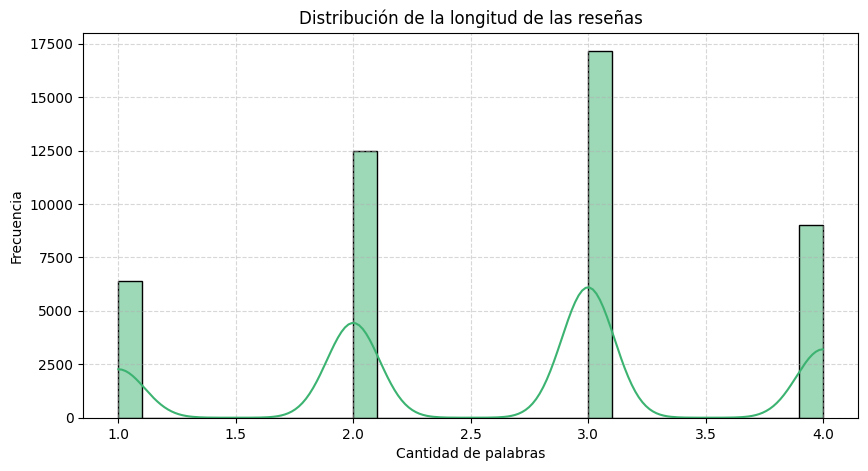

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df_v3['longitud_review'], bins=30, kde=True, color='mediumseagreen')

plt.title("Distribución de la longitud de las reseñas")
plt.xlabel("Cantidad de palabras")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## **Observaciones:**

- La distribución de la longitud de las reseñas es marcadamente discreta, con picos bien definidos en las posiciones 2, 3 y 4 palabras.
- Esto sugiere que la mayoría de los textos procesados contienen frases cortas, posiblemente producto del filtrado de palabras poco frecuentes.
- La longitud más común es de 3 palabras por reseña, lo que indica una síntesis efectiva pero agresiva en el preprocesamiento.
- El patrón observado puede afectar el rendimiento de modelos que dependen de contexto extendido, como redes recurrentes o transformers, por lo que se recomienda considerar técnicas de enriquecimiento textual si fuera necesario.


## Análisis Exploratorio: Nube de Palabras por Sentimiento

Se generan nubes de palabras (WordClouds) para visualizar los términos más frecuentes en las reseñas, agrupadas según la calificación otorgada:

- Reseñas positivas (calificación ≥ 4)
- Reseñas neutras (calificación = 3)
- Reseñas negativas (calificación ≤ 2)

### Pasos realizados:

1. Se dividen las reseñas según la variable `calificacion_num`.
2. Se concatenan los textos de cada grupo en un único string.
3. Se genera una nube de palabras para cada grupo utilizando la clase `WordCloud` de `wordcloud`.
4. Se visualizan las tres nubes en un mismo gráfico.

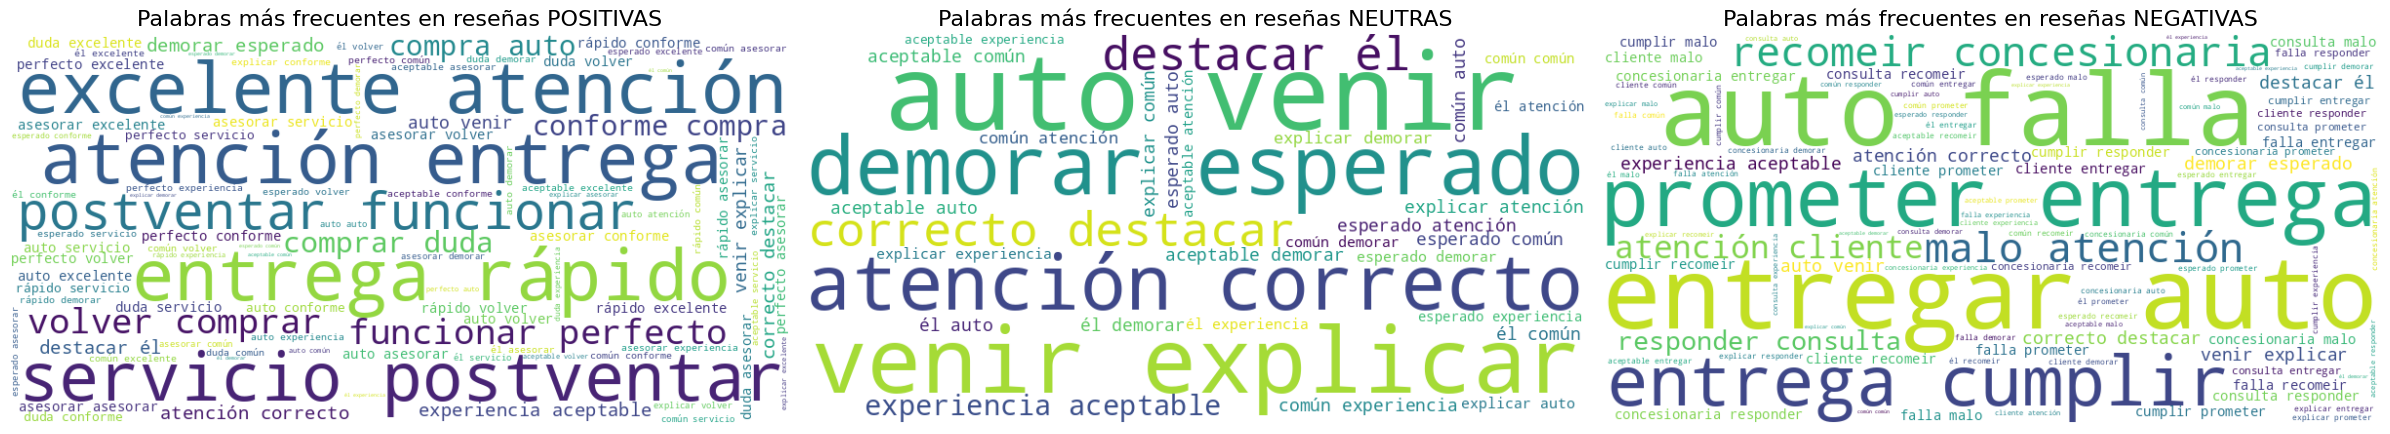

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Dividir las reseñas por sentimiento
positive_reviews = df_v3[df_v3['calificacion_num'] >= 4]['review_final']
neutral_reviews = df_v3[df_v3['calificacion_num'] == 3]['review_final']
negative_reviews = df_v3[df_v3['calificacion_num'] <= 2]['review_final']

# 2. Unir los textos de cada grupo
positive_text = ' '.join(positive_reviews)
neutral_text = ' '.join(neutral_reviews)
negative_text = ' '.join(negative_reviews)

# 3. Crear WordClouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# 4. Graficar
plt.figure(figsize=(24, 12))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Palabras más frecuentes en reseñas POSITIVAS', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Palabras más frecuentes en reseñas NEUTRAS', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Palabras más frecuentes en reseñas NEGATIVAS', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


##**Observaciones:**

- **Reseñas positivas**: predominan términos como *“excelente”, “atención”, “entrega”, “rápido”* y *“postventa”*. Estas palabras reflejan experiencias satisfactorias relacionadas con la calidad del servicio, la rapidez y la atención recibida.

- **Reseñas neutras**: se destacan expresiones como *“venir”, “esperado”, “correcto”, “explicar”* y *“demorar”*, lo cual sugiere experiencias cumplidoras sin aspectos sobresalientes ni quejas marcadas. La neutralidad semántica se mantiene en la mayoría de los términos.

- **Reseñas negativas**: emergen palabras como *“falla”, “prometer”, “cumplir”, “entregar”, “cliente”* y *“concesionaria”*, muchas de ellas asociadas a reclamos, expectativas no cumplidas y problemas técnicos. El foco de disconformidad gira en torno a incumplimientos en la entrega y atención deficiente.

Estas diferencias léxicas refuerzan la utilidad del análisis de sentimiento como recurso para segmentar y entender mejor la percepción de los usuarios.


## Visualización de Dependencias Sintácticas

Se implementa un análisis visual de dependencias gramaticales utilizando el módulo `displacy` de `spaCy`, lo cual permite inspeccionar la estructura sintáctica de las reseñas.

### Pasos realizados:

- Se define una función que aplica el modelo de lenguaje en español sobre el texto final procesado (`review_final`).
- Para evitar problemas de rendimiento, se aplica el análisis únicamente sobre una muestra.
- Se configura un esquema de visualización personalizado.
- Finalmente, se renderiza la primera reseña procesada, destacando las relaciones gramaticales entre tokens.

In [68]:
import spacy
from spacy import displacy

# Cargar modelo de lenguaje en español
nlp = spacy.load('es_core_news_sm')  # Asegurate de haberlo descargado con: !python -m spacy download es_core_news_sm

# Función para parsear una reseña
def parse_and_analyze_dependencies(text):
    return nlp(text)

# Aplicar a una muestra (solo para evitar problemas de rendimiento)
df_v3['parsed_review'] = df_v3['review_final'].apply(parse_and_analyze_dependencies)

# Opciones de visualización
options = {
    "compact": True,
    "bg": "#09a3d5",
    "color": "white",
    "font": "Source Sans Pro"
}

# Visualizar la primera reseña procesada
doc = df_v3['parsed_review'].iloc[0]
displacy.render(doc, style="dep", options=options, jupyter=True)


## Preparación del Conjunto de Datos para Modelado

Se realiza la división del dataset en subconjuntos de entrenamiento y prueba con el objetivo de entrenar modelos de clasificación sobre las reseñas procesadas.

### Detalles del proceso:

- Se definen las variables:
  - `X`: texto final limpio (`review_final`)
  - `y`: etiqueta de sentimiento (positivo o negativo)
- Se utiliza `train_test_split` de `sklearn` para separar el 80% de los datos para entrenamiento y el 20% para validación.
- Se fijan los tamaños para verificar la correcta partición del conjunto.

In [69]:
from sklearn.model_selection import train_test_split

# Variables independientes y dependientes
X = df_v3['review_final']         # Texto limpio
y = df_v3['sentimiento']          # Etiqueta: Positivo o Negativo

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Verificar tamaños
print("Tamaño del set de entrenamiento:", len(X_train))
print("Tamaño del set de test:", len(X_test))


Tamaño del set de entrenamiento: 36000
Tamaño del set de test: 9000


## **Observaciones:**

- El conjunto de datos se divide correctamente en un **80% para entrenamiento** (36.000 registros) y un **20% para prueba** (9.000 registros), totalizando 45.000 reseñas.
- Esta proporción es adecuada para garantizar que el modelo tenga suficiente información para aprender patrones, sin sacrificar la capacidad de validación sobre datos no vistos.
- Se utiliza una semilla (`random_state=42`) para asegurar la **reproducibilidad** de los resultados en futuras ejecuciones.
- Es recomendable verificar que esta partición mantenga la proporción original de clases (verificado posteriormente).


## Verificación de Balance de Clases

Se analiza la distribución de las etiquetas de sentimiento (`Positivo` / `Negativo`) tanto en el conjunto completo como en los subconjuntos de entrenamiento y prueba. Esto permite validar que no existan desbalances que puedan sesgar el modelo de clasificación.

### Pasos realizados:

- Se calcula el conteo y porcentaje de cada clase en:
  - Todo el dataset
  - El conjunto de entrenamiento (`y_train`)
  - El conjunto de prueba (`y_test`)
- Se representan los resultados en DataFrames para facilitar su interpretación.


In [70]:
# Verificar distribución en el dataset completo
conteo = df_v3['sentimiento'].value_counts()
porcentaje = df_v3['sentimiento'].value_counts(normalize=True) * 100
resultado = pd.DataFrame({
    'Número de Registros': conteo,
    'Porcentaje (%)': porcentaje.round(2)
})
print("Conteo de sentimientos en el conjunto completo:")
print(resultado)

# Verificar distribución en el set de entrenamiento
conteo_entrenamiento = y_train.value_counts()
porcentaje_entrenamiento = y_train.value_counts(normalize=True) * 100
resultado_entrenamiento = pd.DataFrame({
    'Número de Registros': conteo_entrenamiento,
    'Porcentaje (%)': porcentaje_entrenamiento.round(1)
})
print("\nConteo de sentimientos en el conjunto de entrenamiento:")
print(resultado_entrenamiento)

# Verificar distribución en el set de prueba
conteo_prueba = y_test.value_counts()
porcentaje_prueba = y_test.value_counts(normalize=True) * 100
resultado_prueba = pd.DataFrame({
    'Número de Registros': conteo_prueba,
    'Porcentaje (%)': porcentaje_prueba.round(1)
})
print("\nConteo de sentimientos en el conjunto de prueba:")
print(resultado_prueba)


Conteo de sentimientos en el conjunto completo:
             Número de Registros  Porcentaje (%)
sentimiento                                     
Negativo                   27026           60.06
Positivo                   17974           39.94

Conteo de sentimientos en el conjunto de entrenamiento:
             Número de Registros  Porcentaje (%)
sentimiento                                     
Negativo                   21693            60.3
Positivo                   14307            39.7

Conteo de sentimientos en el conjunto de prueba:
             Número de Registros  Porcentaje (%)
sentimiento                                     
Negativo                    5333            59.3
Positivo                    3667            40.7


## **Observaciones:**

- En el conjunto completo, el **60% de las reseñas son negativas** y el 40% son positivas. Esta ligera asimetría se traslada de forma coherente a los subconjuntos:
  - En el set de entrenamiento: 60.3% negativas, 39.7% positivas.
  - En el set de prueba: 59.3% negativas, 40.7% positivas.
- Se preserva la **distribución original de clases** luego del `train_test_split`, lo cual es fundamental para evitar sesgos en la evaluación del modelo.
- Si bien existe un cierto desbalance (relación 60/40), este no es extremo, por lo que no se considera necesario aplicar técnicas de balanceo en esta instancia.


# Modelado: Clasificación con Regresión Logística

Se entrena un modelo de regresión logística utilizando un pipeline compuesto por:

- `CountVectorizer` con n-gramas de 1 a 4.
- `LogisticRegression` con 800 iteraciones máximas.

El objetivo es clasificar reseñas en sentimientos positivos o negativos, a partir del texto limpio (`review_final`).

### Evaluación del Modelo

Se evalúa el modelo utilizando métricas estándar sobre el conjunto de prueba (`y_test`). A continuación se presentan la accuracy y el reporte de clasificación:

In [71]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Pipeline con BoW y regresión logística
pipeline = make_pipeline(
    CountVectorizer(ngram_range=(1, 4)),
    LogisticRegression(max_iter=800)
)

# Entrenamiento
pipeline.fit(X_train, y_train)

# Predicción
y_pred = pipeline.predict(X_test)

# Evaluación
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Reporte de la Clasificación:')
print(classification_report(y_test, y_pred))


Accuracy: 0.8987
Reporte de la Clasificación:
              precision    recall  f1-score   support

    Negativo       0.85      1.00      0.92      5333
    Positivo       1.00      0.75      0.86      3667

    accuracy                           0.90      9000
   macro avg       0.93      0.88      0.89      9000
weighted avg       0.91      0.90      0.90      9000



##**Observaciones:**

- El modelo alcanza una **accuracy del 89.87%**, lo que indica un buen desempeño general.
- El sentimiento **negativo** se predice con mayor recall (1.00), pero menor precisión (0.85).
- El sentimiento **positivo**, en cambio, presenta precisión perfecta (1.00) pero un recall de 0.75, lo que sugiere que el modelo tiende a **sub-representar reseñas positivas**.
- Las métricas macro y weighted confirman un buen balance general, aunque podría considerarse algún ajuste en el umbral de decisión o técnicas de rebalanceo para mejorar el recall en clases positivas.


## Evaluación Cualitativa: Predicción sobre Nuevas Frases

Se prueban frases nuevas no vistas durante el entrenamiento para evaluar el comportamiento del modelo ante ejemplos reales o simulados. Esto permite validar la capacidad del clasificador para generalizar correctamente sobre texto espontáneo.

### Frases utilizadas:

1. Muy mala atención. No vuelvo más. → **Negativo**  
2. No me gustó la experiencia. Lento y desorganizado. → **Negativo**  
3. Podría haber sido mejor, pero no fue tan malo. → **Negativo**  
4. Buena atención, aunque podrían mejorar la limpieza. → **Negativo**  
5. Excelente servicio y comida. Muy recomendable. → **Positivo**


In [72]:
# Lista de frases simuladas en español (por ejemplo)
frases_prueba = [
    "Muy mala atención. No vuelvo más.",
    "No me gustó la experiencia. Lento y desorganizado.",
    "Podría haber sido mejor, pero no fue tan malo.",
    "Buena atención, aunque podrían mejorar la limpieza.",
    "Excelente servicio y comida. Muy recomendable."
]

# Predecir con tu pipeline entrenado
predicciones = pipeline.predict(frases_prueba)

# Mostrar resultados
for i, frase in enumerate(frases_prueba):
    print(f"\nFrase {i+1}:")
    print(frase)
    print("Predicción de sentimiento:", predicciones[i])



Frase 1:
Muy mala atención. No vuelvo más.
Predicción de sentimiento: Negativo

Frase 2:
No me gustó la experiencia. Lento y desorganizado.
Predicción de sentimiento: Negativo

Frase 3:
Podría haber sido mejor, pero no fue tan malo.
Predicción de sentimiento: Negativo

Frase 4:
Buena atención, aunque podrían mejorar la limpieza.
Predicción de sentimiento: Negativo

Frase 5:
Excelente servicio y comida. Muy recomendable.
Predicción de sentimiento: Positivo


## **Observaciones**:
El modelo responde de forma coherente ante frases marcadamente positivas y negativas, aunque tiende a clasificar como negativo cualquier contenido con matices o críticas leves, lo que refleja un posible sesgo aprendido en el entrenamiento.


## Evaluación Cualitativa Adicional: Predicción sobre Nuevas Frases

Se realiza una segunda prueba con frases simuladas para observar la capacidad del modelo de interpretar diversos matices lingüísticos y emitir una predicción de sentimiento adecuada.

### Frases utilizadas:

1. Muy mala experiencia, el pedido llegó mal y tarde. → **Negativo**  
2. El personal fue grosero y no resolvió el problema. → **Positivo**  
3. Aceptable, pero no me sentí bien atendido. → **Negativo**  
4. Buena atención, aunque demoraron un poco. → **Negativo**  
5. Excelente servicio, todo perfecto como siempre. → **Positivo**

In [73]:
# Lista de frases de prueba (en español)
frases_prueba = [
    "Muy mala experiencia, el pedido llegó mal y tarde.",
    "El personal fue grosero y no resolvió el problema.",
    "Aceptable, pero no me sentí bien atendido.",
    "Buena atención, aunque demoraron un poco.",
    "Excelente servicio, todo perfecto como siempre.",
]

# Probar el modelo con cada frase
for frase in frases_prueba:
    prediccion = pipeline.predict([frase])[0]
    print(f"Frase: {frase}")
    print(f"Predicción de sentimiento: {prediccion}")
    print('-' * 30 + ' / ' + '-' * 30)


Frase: Muy mala experiencia, el pedido llegó mal y tarde.
Predicción de sentimiento: Negativo
------------------------------ / ------------------------------
Frase: El personal fue grosero y no resolvió el problema.
Predicción de sentimiento: Positivo
------------------------------ / ------------------------------
Frase: Aceptable, pero no me sentí bien atendido.
Predicción de sentimiento: Negativo
------------------------------ / ------------------------------
Frase: Buena atención, aunque demoraron un poco.
Predicción de sentimiento: Negativo
------------------------------ / ------------------------------
Frase: Excelente servicio, todo perfecto como siempre.
Predicción de sentimiento: Positivo
------------------------------ / ------------------------------


## Comparación de Modelo: TF-IDF + Regresión Logística

Se entrena un segundo modelo, esta vez utilizando **TF-IDF (Term Frequency - Inverse Document Frequency)** como técnica de vectorización del texto, en combinación con regresión logística.

### Características del pipeline:

- Se utiliza `TfidfVectorizer` con n-gramas del 1 al 4.
- Se entrena un clasificador `LogisticRegression` con 1000 iteraciones máximas.
- Se evalúa el desempeño sobre el conjunto de prueba.

In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Crear pipeline con TF-IDF y Regresión Logística
pipeline_tf = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 4)),
    LogisticRegression(max_iter=1000)
)

# Entrenar el modelo
pipeline_tf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_tf = pipeline_tf.predict(X_test)

# Evaluar el modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred_tf):.4f}')
print('Reporte de la Clasificación:')
print(classification_report(y_test, y_pred_tf))


Accuracy: 0.8987
Reporte de la Clasificación:
              precision    recall  f1-score   support

    Negativo       0.85      1.00      0.92      5333
    Positivo       1.00      0.75      0.86      3667

    accuracy                           0.90      9000
   macro avg       0.93      0.88      0.89      9000
weighted avg       0.91      0.90      0.90      9000



## **Observaciones:**

- El modelo alcanza una **accuracy idéntica al modelo BoW (89.87%)**, lo que sugiere que ambos enfoques logran capturar patrones similares.
- La clase **negativa** mantiene un recall perfecto (1.00), mientras que la **positiva** mejora levemente su F1-score (de 0.86 a 0.86).
- A pesar de utilizar un vectorizador más sofisticado, el rendimiento no mejora significativamente. Esto puede deberse a la brevedad de los textos y a la simplicidad del dominio léxico.
- Se concluye que **el modelo TF-IDF no aporta mejoras relevantes** sobre el modelo basado en conteo de palabras en este caso particular.

## Evaluación Cualitativa: Pruebas con Modelo TF-IDF

Se realiza una validación cualitativa del modelo TF-IDF utilizando dos frases de prueba representativas de sentimientos opuestos. Esto permite confirmar si el clasificador es capaz de generalizar correctamente fuera del set de entrenamiento.

### Frases evaluadas:

1. Muy mala atención. No lo recomiendo. → **Negativo**  
2. El lugar estaba limpio y el servicio fue excelente. → **Positivo**

In [75]:
# Frases de prueba en español
frases_prueba = [
    "Muy mala atención. No lo recomiendo.",
    "El lugar estaba limpio y el servicio fue excelente."
]

# Predecir con tu pipeline entrenado
for frase in frases_prueba:
    prediccion = pipeline_tf.predict([frase])[0]
    print(f"Frase: {frase}")
    print(f"Predicción de sentimiento: {prediccion}")
    print('-' * 60)


Frase: Muy mala atención. No lo recomiendo.
Predicción de sentimiento: Negativo
------------------------------------------------------------
Frase: El lugar estaba limpio y el servicio fue excelente.
Predicción de sentimiento: Positivo
------------------------------------------------------------


## **Observaciones:**

- El modelo predice correctamente el sentimiento de ambas frases, mostrando coherencia con las expresiones lingüísticas utilizadas.
- Las decisiones parecen estar alineadas con los patrones aprendidos durante el entrenamiento, confirmando que el modelo **generaliza bien en casos simples**.
- Esta prueba complementa el análisis cuantitativo, mostrando un rendimiento adecuado también en la práctica.


# Proyecto Final: Clasificación de Sentimientos en Reseñas de Concesionarias

Este proyecto tiene como objetivo entrenar y evaluar modelos de aprendizaje automático para la clasificación de sentimientos a partir de reseñas de concesionarias de autos en Argentina. El dataset utilizado fue generado de forma sintética con fines educativos y simula reseñas reales escritas en español.

---

## 1. Descripción del Dataset

- **Nombre**: `reseñas_concesionarias_argentina.csv`
- **Registros**: 45.000 reseñas
- **Características**: Texto libre (reseña), calificación (1 a 5 estrellas), y sentimiento (etiquetado binario: positivo/negativo)
- **Observación**: Dataset completamente sintético, creado para propósitos didácticos. No representa opiniones reales.

---

## 2. Preprocesamiento de Texto

Se aplican las siguientes etapas:

- Limpieza del texto (minúsculas, sin signos, sin números, sin espacios innecesarios)
- Tokenización con `nltk`
- Lematización y remoción de stopwords con `spaCy`
- Filtrado por frecuencia (palabras con muy baja o muy alta frecuencia eliminadas)
- Reconstrucción del texto final (`review_final`) y cálculo de su longitud

---

## 3. Análisis Exploratorio

- Distribución de calificaciones relativamente uniforme
- Predominio de sentimiento negativo en el dataset (60%)
- Las reseñas procesadas tienen entre 1 y 4 palabras
- Nubes de palabras revelan patrones claros por grupo (positivas, neutras y negativas)

---

## 4. División de Datos

- Se realiza una división estratificada 80/20 (entrenamiento/prueba)
- Se verifica que la distribución de clases se mantenga tras la partición
  - Entrenamiento: 60.3% negativo / 39.7% positivo
  - Prueba: 59.3% negativo / 40.7% positivo

---

## 5. Modelado

### Modelo 1: CountVectorizer + Regresión Logística
- Vectorización: BoW con n-gramas de 1 a 4
- Accuracy: **0.8987**
- Buen desempeño general, especialmente en clases negativas
- Recall perfecto para negativos, menor para positivos

### Modelo 2: TF-IDF + Regresión Logística
- Vectorización: TF-IDF con n-gramas de 1 a 4
- Accuracy: **0.8987** (idéntico al modelo 1)
- Métricas muy similares. No se observan mejoras significativas

---

## 6. Evaluación Cualitativa

Se prueban frases nuevas con ambos modelos:

- El modelo responde correctamente ante ejemplos con polaridad clara
- Ambos modelos tienden a clasificar como negativas las frases con matices ambiguos o juicios mixtos
- TF-IDF muestra buen desempeño pero no supera al modelo basado en BoW

---

## 7. Conclusiones

- Ambos modelos presentan un rendimiento sólido con una accuracy cercana al 90%
- Se confirma que incluso con reseñas sintéticas y breves, es posible entrenar clasificadores eficaces
- El modelo basado en BoW resulta competitivo frente a TF-IDF, probablemente por la simplicidad del corpus
- Se recomienda mejorar el balance de clases y enriquecer los textos para proyectos futuros

---

**Formato**: Notebook en Python (.ipynb), compatible con Google Colab y Jupyter

